In [7]:
import os
import gdal
import ogr
import fiona
from fiona import crs
import shapely
import logging
import matplotlib.pyplot as plt

from osm2dh import filter_features, create_feature, multi2single_geoms, check_data_model, write_layer
from shapely_tools import snap_lines, split_lines

import copy
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import xml
# from DFlowFM_tools import write_layer

# osm_fn = r'd:\OneDrive\projects\1230843_Challenge_Fund\training_folder\data\OpenStreetMap\manzese.osm'
osm_fn = r'd:\tools\HYDTools\sandbox\osmmodelbuilding\input\manzese.osm'
key = 'waterway'
value = ['river', 'stream', 'canal', 'drain', 'ditch', 'drystream']
layer_index = 1
check_fields = {
                'width': float,
                'depth': float,
                'covered': str,
                'layer': int,
                'diameter': float
                }
prop_types = {}
for field in check_fields.keys():
    prop_types[field] = check_fields[field].__name__
check_values = {'width': [2, 3],
               'depth': [],
               'covered': ['yes', 'dirt', 'garbage'],
               'layer': [-1],
               'diameter': [],
               }
schema = {
          'geometry': 'LineString',  # TODO find geometry type in layer
          'properties': prop_types,
         }
print key


waterway


In [2]:
# plot functions
import matplotlib.pyplot as plt
%matplotlib inline

def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=3)

def plot_point(ax, ob, color='#000000'):
    x, y = ob.xy
    ax.plot(x, y, 'o', color=color, zorder=4, markersize=7)
    
def plot_bounds(ax, ob, color='#000000', marker='o'):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, marker, color=color, zorder=3)

def plot_line(ax, ob, color):
    x, y = ob.xy
    ax.plot(x, y, color=color, alpha=0.7, linewidth=2, solid_capstyle='round', zorder=2)
    

def baseplot(lines, title='', ax=None, color='grey'):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(5, 5))
    for line in lines:
        plot_line(ax, line, color)
#        plot_bounds(ax, line)
#        plot_coords(ax, line)       

    ax.set_title(title)
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)

In [3]:
def check_connectivity(osm_features, select_id, tolerance):
    
    # First step is to select inital starting point
    select_geom          = [osm_features[select_id]]
    select_geom[0]['id'] = select_id
    select_geom_ini      = geoms[select_id]
    
    connected = []
    j=0
    # We loop untill no new upstream features are found
    # This might need some updating, can go in infinite loop!!
    while not len(select_geom) == 0:
        j=j+1
        print "Iteration %s, checking %s new elements" %(j, len(select_geom))
        new_features = []
        # Now loop of the selected geometry, which is updated with the connected geometry.
        for geo in select_geom:
            # Now loop over all features to see if it is disjoint or not.
            for feature in osm_features[:]:
                if feature['geometry'].disjoint(geo['geometry'].buffer(tolerance)):
                    continue
                else:
                    connected.append(feature)
                    new_features.append(feature)
                    osm_features.remove(feature)
                    
        select_geom = copy.deepcopy(new_features)
    return connected



In [4]:
filtered = filter_features(osm_fn, key=key, value=value,
                               layer_index=layer_index, wgs2utm=False, logger=logging)

checked  = check_data_model(filtered, check_keys=check_fields, check_values=check_values, schema=schema,
                     keep_original=False, flag_suffix='_flag', logger=logging)

geoms = [feat['geometry'] for feat in checked]

tolerance = 0.0001
idx       = 100

connected    = check_connectivity(checked, idx, tolerance)
connected_   = [feat['geometry'] for feat in connected]

Iteration 1, checking 1 new elements
Iteration 2, checking 5 new elements
Iteration 3, checking 11 new elements
Iteration 4, checking 18 new elements
Iteration 5, checking 23 new elements
Iteration 6, checking 41 new elements
Iteration 7, checking 25 new elements
Iteration 8, checking 41 new elements
Iteration 9, checking 31 new elements
Iteration 10, checking 36 new elements
Iteration 11, checking 41 new elements
Iteration 12, checking 43 new elements
Iteration 13, checking 23 new elements
Iteration 14, checking 17 new elements
Iteration 15, checking 9 new elements
Iteration 16, checking 2 new elements
Iteration 17, checking 3 new elements
Iteration 18, checking 1 new elements
Iteration 19, checking 1 new elements


In [5]:
filtered[1]

{'geometry': <shapely.geometry.linestring.LineString at 0xd3ea5f8>,
 'properties': {'aerialway': None,
  'all_tags': '"waterway"=>"stream"',
  'barrier': None,
  'bridge': None,
  'covered': None,
  'depth': None,
  'diameter': None,
  'highway': None,
  'layer': None,
  'man_made': None,
  'name': None,
  'osm_id': '126187290',
  'radius': None,
  'sidewalks': None,
  'tunnel': None,
  'waterway': 'stream',
  'width': None,
  'z_order': 0}}

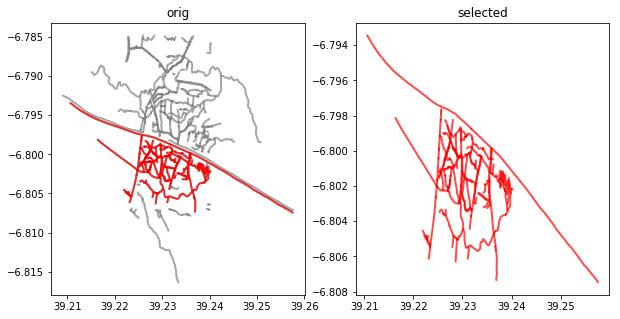

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
baseplot(geoms, 'orig', ax=ax[0])
baseplot(connected_, 'orig', ax=ax[0],color='r')
baseplot(connected_, 'selected', ax=ax[1],color='r')
##
fn_out_connected = 'connected.json'
fn_out_checked   = 'checked.json'

prop_with_flags = {}
for prop in prop_types.keys():
    prop_with_flags[prop] = prop_types[prop]
    prop_with_flags[prop + '_flag'] = 'int'

schema = {
          'geometry': 'LineString',  # TODO find geometry type in layer
          'properties': prop_with_flags,
         }

write_layer(fn_out_connected, None, connected, 
                   format='GeoJSON', write_mode='w', crs=fiona.crs.from_epsg(4326), schema=schema, logger=logging)

write_layer(fn_out_checked, None, checked, schema=schema,
                   format='GeoJSON', write_mode='w', crs=fiona.crs.from_epsg(4326), logger=logging)